In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [29]:

import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
import gpflow
import tensorflow as tf
from gpflow.config import default_float
import tensorflow_probability as tfp
from data.get_data import get_tubingen_pairs_dataset, get_synthetic_dataset
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(0)
np.random.seed(0)

In [30]:
x, y, weight = get_synthetic_dataset(
    num_datasets=100,
    sample_size=100,
    func_string="mult_a",
    noise="uniform"
)
x = (x - x.mean(axis=1)[:, None, :]) / x.std(axis=1)[:, None, :]
y = (y - y.mean(axis=1)[:, None, :]) / y.std(axis=1)[:, None, :]
input, output = y[3], x[3]

In [31]:
x, y, weight = get_tubingen_pairs_dataset(
    data_path='/vol/bitbucket/ad6013/Research/gp-causal/data/pairs/files'
)
input, output = y[4], x[4]
input = (input - input.mean(axis=0)[:, None]) / input.std(axis=0)[:, None]
output = (output - output.mean(axis=0)[:, None]) / output.std(axis=0)[:, None]

Load cause-effect pairs: 100%|██████████| 100/100 [00:00<00:00, 264.92it/s]


In [32]:
input.std()

1.0

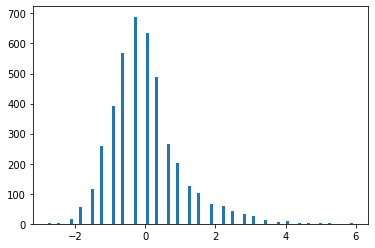

In [33]:
import matplotlib.pyplot as plt
import numpy as np


plt.hist(output[:, 0], bins=100)
plt.show()

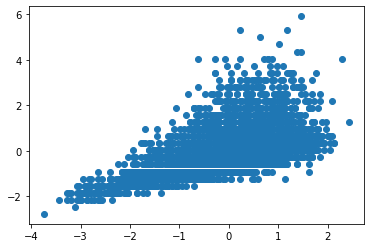

In [34]:
plt.scatter(input[:, 0], output[:, 0])
plt.show()

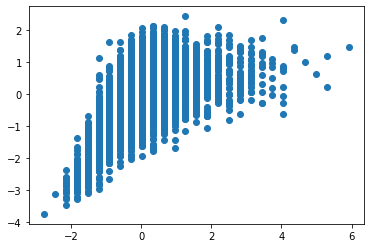

In [35]:
plt.scatter(output[:, 0], input[:, 0])
plt.show()

In [19]:
from gpflow.base import Parameter
from gpflow.utilities import positive




num_inducing = 75

kernel_variance = 5
kernel_lengthscale = 3
# likelihood_variance = 1
likelihood_variance = Parameter( 1. / (0.2 ** 2), transform=positive(lower=0.01))

sq_exp = gpflow.kernels.SquaredExponential()
sq_exp.variance.assign(kernel_variance)
    # lambda = 5 in this
sq_exp.lengthscales.assign(kernel_lengthscale)

m_gpr = gpflow.models.GPR(data=(input, output), kernel=sq_exp, mean_function=None)
m_gpr.likelihood.variance = likelihood_variance
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m_gpr.training_loss, m_gpr.trainable_variables, options=dict(maxiter=10000)
)

In [20]:
x_new = np.linspace(-5, 5, 1000)[:, None]
pred_f, var_f = m_gpr.predict_y(x_new)

In [21]:
from gpflow.utilities import print_summary
print_summary(m_gpr)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 5.03958  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 2.23968  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.891645 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧══════

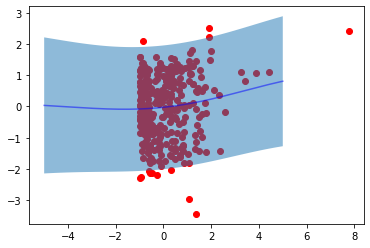

In [11]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(x_new, pred_f, c='b', alpha=0.5)
plt.fill_between(x_new[:, 0], (pred_f + 2 * np.sqrt(var_f))[:, 0], (pred_f - 2 * np.sqrt(var_f))[:, 0], alpha=0.5)
plt.show()

In [13]:
 - m_gpr.log_marginal_likelihood().numpy()

495.61032527464323

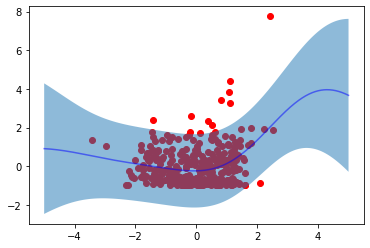

In [23]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.plot(x_new, pred_f, c='b', alpha=0.5)
plt.fill_between(x_new[:, 0], (pred_f + 2 * np.sqrt(var_f))[:, 0], (pred_f - 2 * np.sqrt(var_f))[:, 0], alpha=0.5)
plt.show()

In [24]:
- m_gpr.log_marginal_likelihood().numpy()

484.53350554924594

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

tf.config.list_physical_devices('GPU')

2022-05-24 17:39:07.953504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 17:39:07.954158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 17:39:07.954198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-24 17:39:07.954232: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-24 17:39:07.954265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

[]

In [36]:
from gpflow.base import Parameter
from gpflow.utilities import positive

tf.config.run_functions_eagerly(False)

# for i in range(500):
# x, y, weight = get_synthetic_dataset(
#     num_datasets=100,
#     sample_size=100,
#     func_string="mult_a",
#     noise="uniform"
# )
# x = (x - x.mean(axis=1)[:, None, :]) / x.std(axis=1)[:, None, :]
# y = (y - y.mean(axis=1)[:, None, :]) / y.std(axis=1)[:, None, :]

# input, output = x[0], y[0]

kernel_variance = 1.0
# Likelihood variance
kappa = np.random.uniform(
    low=1.0, high=100, size=[1]
)
# Kernel lengthscale
lamda = np.random.uniform(
    low=1.0, high=10, size=[2]
)

latent_dim = 1
num_inducing = 100

kernel_lengthscale = 1. / lamda
likelihood_variance = Parameter( 1. / (kappa ** 2), transform=positive(lower=1e-6))

print(f"Initial hyper: lengthscale - {kernel_lengthscale}, variance - {likelihood_variance.numpy()}")

sq_exp = gpflow.kernels.SquaredExponential()
sq_exp.variance.assign(kernel_variance)
    # lambda = 5 in this
sq_exp.lengthscales.assign(kernel_lengthscale[0])

m = gpflow.models.GPR(data=(input, output), kernel=sq_exp, mean_function=None)
m.likelihood.variance = likelihood_variance[0]
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss, m.trainable_variables, options=dict(maxiter=10000)
)
# found_lengthscales = [m.kernel.kernels[0].lengthscales.numpy(), m.kernel.kernels[1].lengthscales.numpy(), m.kernel.kernels[2].lengthscales.numpy()]
found_lengthscale = m.kernel.lengthscales.numpy()
found_lik_var = m.likelihood.variance.numpy()

X_mean_init = output - m.predict_f(input)[0]
# X_mean_init = tfp.distributions.Normal(loc=0, scale=1).sample([y.shape[0], latent_dim])
# X_mean_init = tf.cast(X_mean_init, dtype=default_float())
X_var_init = tf.ones((input.shape[0], latent_dim), dtype=default_float())
kernel = gpflow.kernels.SquaredExponential(lengthscales=[found_lengthscale] + [kernel_lengthscale[1]] * latent_dim)

m = PartObsBayesianGPLVM(
    data=output,
    in_data=input,
    kernel=kernel,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    num_inducing_variables=num_inducing,
)
m.likelihood.variance = Parameter( found_lik_var, transform=positive(lower=1e-6))

# Train only inducing variables
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train only x_var
gpflow.utilities.set_trainable(m.kernel, False)
gpflow.utilities.set_trainable(m.likelihood, False)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train all the hyperparameters
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , False)
gpflow.utilities.set_trainable(m.X_data_var, False)
gpflow.utilities.set_trainable(m.inducing_variable, False)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

# Train everything
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
gpflow.utilities.set_trainable(m.X_data_mean , True)
gpflow.utilities.set_trainable(m.X_data_var, True)
gpflow.utilities.set_trainable(m.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

Initial hyper: lengthscale - [0.61883171 0.13313174], variance - [0.00054382]


In [ ]:
from gpflow.utilities import print_summary
print_summary(m)

╒══════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤══════════════════════════════════════╕
│ name                                     │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                                │
╞══════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪══════════════════════════════════════╡
│ PartObsBayesianGPLVM.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 4.8897554654502314e-08               │
├──────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼──────────────────────────────────────┤
│ PartObsBayesianGPLVM.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)     │ float64 │ [3.70035018e-05 5.05022419e-01]      │
├───────────────────────────────────────

In [ ]:
- m.elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=495.2095570300378>

In [12]:
obs_new = np.linspace(-20, 20, 4000)[:, None]

Xnew = tfp.distributions.Normal(loc=0, scale=1).sample([obs_new.shape[0], latent_dim])
Xnew = tf.cast(Xnew, dtype=default_float())
Xnew = tf.concat(
    [obs_new, Xnew], axis=1
)
pred_f_mean, pred_f_var = m.predict_f(
    in_data_new=input,
    Xnew=Xnew,
)

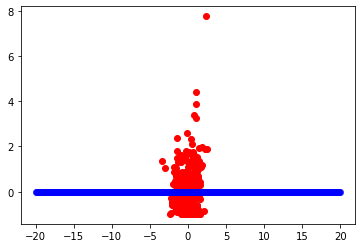

In [13]:
plt.scatter(input[:, 0], output[:, 0], c='r')
plt.scatter(obs_new, pred_f_mean, c='b', alpha=0.1)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_f_mean + 2 * np.sqrt(pred_f_var))[:, 0], (pred_f_mean - 2 * np.sqrt(pred_f_var))[:,0], alpha=0.5)
plt.show()

In [38]:
-m.elbo().numpy()

687.4419320636074

In [22]:
-m.elbo().numpy()

-499.09120544465554

In [87]:
-945.981557225954 < -751.9391785862274

True

In [24]:
plt.scatter(x[0, :, 0], y[0, :, 0], c='r')
plt.scatter(x[0], pred_f_mean, c='b', alpha=0.5)
plt.ylim(-20, 20)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [15]:
- m.elbo().numpy()

119.29262107485727

In [159]:
gplvm_in = y[2]
tf.config.run_functions_eagerly(False)


In [14]:
kernel_lengthscale = 1. / 5
likelihood_variance = 1. / (20 ** 2)
num_inducing = 100
latent_dim = 1
kernel_variance = 1.0

X_mean_init = tfp.distributions.Normal(loc=0, scale=1).sample([gplvm_in.shape[0], latent_dim])
X_mean_init = tf.cast(X_mean_init, dtype=default_float())
X_var_init = tf.ones((gplvm_in.shape[0], latent_dim), dtype=default_float())
sq_exp = gpflow.kernels.SquaredExponential() 
sq_exp.variance.assign(kernel_variance)
sq_exp.lengthscales.assign(1. / 10)

mat32 = gpflow.kernels.Matern32() 
mat32.variance.assign(kernel_variance)
mat32.lengthscales.assign(1. / 10)

mat52 = gpflow.kernels.Matern52() 
mat52.variance.assign(kernel_variance)
mat52.lengthscales.assign(1. /8)

kernel = gpflow.kernels.Sum([sq_exp, mat32, mat52])

m = gpflow.models.BayesianGPLVM(
    data=gplvm_in,
    kernel=kernel,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    num_inducing_variables=num_inducing,
    )
m.likelihood.variance.assign(likelihood_variance)

NameError: name 'gplvm_in' is not defined

In [161]:
# Only train variational parameters first
# gpflow.utilities.set_trainable(m.kernel, False)
# gpflow.utilities.set_trainable(m.likelihood, False)
# opt = gpflow.optimizers.Scipy()
# opt_logs = opt.minimize(
#     m.training_loss,
#     m.trainable_variables,
#     options=dict(maxiter=100),
# )

# Train all the parameters
gpflow.utilities.set_trainable(m.kernel, True)
gpflow.utilities.set_trainable(m.likelihood, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=10000),
)

In [ ]:
help(opt_logs)

Help on OptimizeResult in module scipy.optimize._optimize object:

class OptimizeResult(builtins.dict)
 |  Represents the optimization result.
 |  
 |  Attributes
 |  ----------
 |  x : ndarray
 |      The solution of the optimization.
 |  success : bool
 |      Whether or not the optimizer exited successfully.
 |  status : int
 |      Termination status of the optimizer. Its value depends on the
 |      underlying solver. Refer to `message` for details.
 |  message : str
 |      Description of the cause of the termination.
 |  fun, jac, hess: ndarray
 |      Values of objective function, its Jacobian and its Hessian (if
 |      available). The Hessians may be approximations, see the documentation
 |      of the function in question.
 |  hess_inv : object
 |      Inverse of the objective function's Hessian; may be an approximation.
 |      Not available for all solvers. The type of this attribute may be
 |      either np.ndarray or scipy.sparse.linalg.LinearOperator.
 |  nfev, njev, nh

In [ ]:
from gpflow.utilities import print_summary
print_summary(m)

╒══════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤══════════╤═════════╤════════════════════════╕
│ name                                         │ class     │ transform        │ prior   │ trainable   │ shape    │ dtype   │ value                  │
╞══════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪══════════╪═════════╪════════════════════════╡
│ BayesianGPLVM.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 4.642696535423026e-10  │
├──────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼──────────┼─────────┼────────────────────────┤
│ BayesianGPLVM.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()       │ float64 │ 0.6538335049036416     │
├──────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼───────────

In [ ]:
pred_y_mean, pred_y_var = m.predict_y(Xnew=m.X_data_mean)

In [ ]:
m.X_data_mean.numpy()

array([[-2.27307869e-05],
       [-4.06347080e-05],
       [ 3.05863410e-05],
       [-9.88247690e-05],
       [-1.01621277e-05],
       [-8.33839855e-05],
       [ 3.48348364e-05],
       [ 1.22844895e-05],
       [-4.61329404e-05],
       [ 3.35000910e-05],
       [ 1.88067680e-05],
       [-3.87149573e-05],
       [ 5.99923083e-05],
       [-6.14941876e-05],
       [-1.39356709e-05],
       [-2.56035705e-05],
       [ 7.33277375e-06],
       [ 5.31022301e-05],
       [ 3.35905608e-05],
       [-1.03958361e-05],
       [ 8.91291472e-06],
       [-2.87223920e-05],
       [-3.49838684e-05],
       [-5.40743108e-05],
       [-2.71024628e-05],
       [-2.14482471e-05],
       [ 1.42173227e-04],
       [ 4.35213205e-05],
       [-4.16952372e-05],
       [ 9.75459855e-05],
       [-4.45036246e-05],
       [-1.46207987e-05],
       [-2.57756777e-06],
       [-5.61287966e-05],
       [-3.21974087e-05],
       [-3.51922648e-05],
       [-5.48341748e-05],
       [ 4.85166061e-05],
       [ 3.6

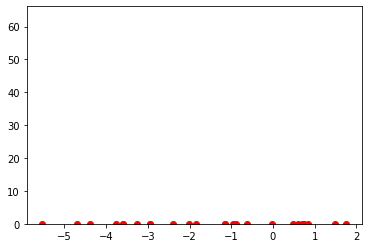

In [ ]:
import matplotlib.pyplot as plt


plt.hist(m.X_data_mean.numpy(), bins=2, alpha=0.7)
plt.scatter(m.inducing_variable.Z, np.zeros(num_inducing), c='r')
plt.show()

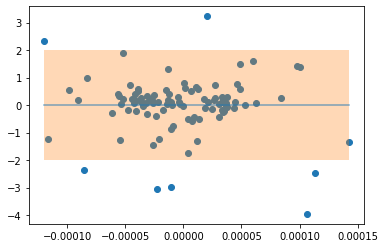

In [ ]:


ind = np.argsort(m.X_data_mean[:, 0])
x_values = np.take_along_axis(m.X_data_mean.numpy()[:, 0], ind, axis=0)
pred_y_mean_new = np.take_along_axis(pred_y_mean.numpy()[:, 0], ind, axis=0) 
pred_y_var_new = np.take_along_axis(pred_y_var.numpy()[:, 0], ind, axis=0)

plt.scatter(m.X_data_mean, gplvm_in)
plt.plot(x_values, pred_y_mean_new, alpha=0.6)
plt.fill_between(x_values, (pred_y_mean_new + 2 * np.sqrt(pred_y_var_new)), (pred_y_mean_new - 2 * np.sqrt(pred_y_var_new)), alpha=0.3)
plt.show()

In [ ]:
-m.elbo().numpy()

141.89385729808907

In [98]:
from scipy.stats import norm
def ml_estimate(x):
    """
    Find the log likelihood.

    This doesn't make sense after I have normalised the data.
    """
    score = - np.sum( np.log(
            norm.pdf(x, loc=x.mean(), scale=x.std())

    ))
    print(norm.pdf(x, loc=x.mean(), scale=x.std()))
    return score

In [86]:
print( ml_estimate(x[2]), ml_estimate(y[2]), ml_estimate(np.random.normal(0, 1.5, 10000)))

[[0.2326027 ]
 [0.31852053]
 [0.13892459]
 ...
 [0.35506125]
 [0.39891987]
 [0.17203474]]
[[0.36215618]
 [0.38905551]
 [0.28767247]
 ...
 [0.3981433 ]
 [0.39889956]
 [0.258324  ]]
[0.17355695 0.26539336 0.1214141  ... 0.23633496 0.25741284 0.03818973]
14189.385332046726 14189.385332046728 18214.40122066285


In [8]:
tf.config.list_physical_devices('GPU')


[]

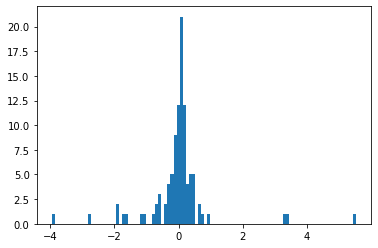

In [251]:
plt.hist(y[2], bins=100)
plt.show()

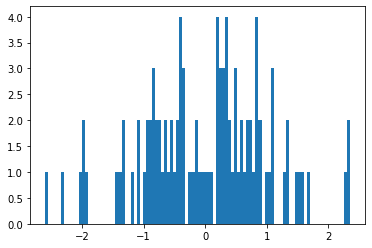

In [75]:
plt.hist(x[2], bins=100)
plt.show()

In [14]:
a = tf.Variable(1.0)
tf.debugging.check_numerics(a, message='')

b = tf.Variable(np.nan)
# try:
tf.debugging.check_numerics(b, message='Checking b')
# except Exception as e:
#   assert "Checking b : Tensor had NaN values" in e.message

c = tf.Variable(np.inf)
try:
  tf.debugging.check_numerics(c, message='Checking c')
except Exception as e:
  assert "Checking c : Tensor had Inf values" in e.message

InvalidArgumentError: Checking b : Tensor had NaN values [Op:CheckNumerics]

In [9]:
5541508.04182404 / 0.3

18471693.4727468

In [10]:
18471693.4727468

18471693.4727468